<a href="https://colab.research.google.com/github/agroimpacts/nmeo/blob/class%2Ff2023/materials/code/notebooks/planet_downloader_retiler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading and preparing PlanetScope data

This notebook provides instructions for working with selected samples to query the Planet API, download the necessary NICFI tiles by date, and then reprocess them into tiles defined by a different grid format.

## Requirements

### Files
You will need one input file:

- malawi_tiles_buf179.geojson

This file is the one you will select a subset from to collect NICFI tiles, and then retile them. You will have to select an area of 5X5 tiles first.


## Instructions
Select a new AOI in Malawi then the one you ran in the class exercise, making sure it only intersects about 10-20 tiles

Query the Planet API to download the quads intersecting that new AOI, reproject
and retile the quads into each tile polygon (as we did in class), making a COG of each.

Use leafmap to show a randomly selected retiled sample against your selected tile grid.

Create a STAC catalog of the retiled images on Google Drive, porting the procedures we used on SageMaker to colab (see sagemaker-geo-demo.ipynb).

Print the properties of the catalog items

As above, use the minimum code necessary to complete the task.

10 point bonus: Instead of using sklearn to do the kmeans clustering, replace that workflow with one based on ee and geemap, so that the kmeans clustering is done on Google Earth Engine. That will require first transferring the processed
Planet tiles to Earth Engine as assets first.

### Code
You will first have to install the clone our `maputil` repository from GitHub, which can be collected done by running the code below (first we mount Drive)

In [1]:
from google.colab import drive
root = '/content/gdrive'
drive.mount(root)

Mounted at /content/gdrive


#### Clone and/or update maputil

In [2]:
# from datetime import datetime as dt
import os
repo_path = f"{root}/MyDrive/Earth_Observations/Homework/Part2/repos"
clone_path = 'https://github.com/agroimpacts/maputil.git'
if not os.path.exists(repo_path):
    print(f"Making {repo_path}")
    os.makedirs(repo_path, exist_ok=True)

if not os.path.exists(f"{repo_path}/maputil"):
    !git -C "{repo_path}" clone "{clone_path}"
else:
    !git -C "{repo_path}/maputil" pull

Already up to date.


### Install and import other necessary packages

In [3]:
%%capture
%pip install affine
%pip install leafmap
%pip install localtileserver
%pip install leafmap
%pip install boto3
%pip install urllib3==2.0.3
%pip install rio-cogeo
#%pip install rioxarray
%pip install pysnic

In [ ]:
import os
root = '/content/gdrive'
repo_path = f"{root}/MyDrive/Earth_Observations/Homework/Part2/repos"

import sys
import importlib
from pathlib import Path
import affine
import pandas as pd
import leafmap.leafmap as leafmap
import localtileserver
import geopandas as gpd
import inspect
from rasterio.plot import show

sys.path.insert(0, repo_path)
import maputil
importlib.reload(maputil)
from maputil.maputil import *


## Set up the parameters to run the downloader

In [ ]:
#@title #### Enter path to Planet key
x = input("Enter the path on Drive where your key is stored, "\
          "e.g. keys/mykey.txt: ")
key_path = f"{root}/MyDrive/{x}"

PLANET_API_KEY = open(key_path).read().strip()

Enter the path on Drive where your key is stored, e.g. keys/mykey.txt: Earth_Observations/myPlanetAPIKey.txt


Set parameters and paths data and other data downloads

- API_URL_KEY: Provided
- proj_path: The path where you want to place all files
- quad_dir: The place to download Planet basemap quads
- tile_dir: The place where tile clipped out of basemap quads will go
- temp_dir: The place where temporary files to be made during clipping out the tile go
- dst_width: The output width in pixels of the final PlanetScope tile (2368)
- dst_height: The output width in pixels of the final PlanetScope tile (2368)
- nbands: The number of output bands in the imagery (4)
- dst_crs: The output coordinate reference system ('EPSG=4326')
- tile_path: The path to the tile file provided for this exercise (malawi_tiles_full.geojson), which you can get [here](https://drive.google.com/file/d/1yTFp7IjvCVvPr9mBRD8L5PC20oGc_g5I/view?usp=sharing).

Change the paths below to match those on your system.

In [ ]:
API_URL = 'https://api.planet.com/basemaps/v1/mosaics'

# main output path were all the other pasth are stored
proj_path = f"{root}/MyDrive/Earth_Observations/Homework/Part2"
os.makedirs(proj_path, exist_ok=True)

quad_dir = f"{proj_path}/quads"  # for downloaded NICFI quads
tile_dir = f"{proj_path}/tiles"  # for output tiles
temp_dir = f"{proj_path}/temp"   # temporary directory for intermediate outputs
log_dir = f"{proj_path}/logs"  # directory for log files
analyses_dir = f"{proj_path}/analyses"  # for output tiles
if not os.path.exists(analyses_dir):
    os.makedirs(analyses_dir, exist_ok=True)

# output parameters for tiles
dst_width = 2358
dst_height = 2358
nbands = 4
dst_crs = 'EPSG:4326'

# malawi tiles
tile_path = f"{proj_path}/inputs/malawi_tiles_buf179.geojson"

### Read in tile file and select sub-area

Using the Malawi tiles

In [ ]:
tiles = gpd.read_file(tile_path)
tiles[tiles.columns[0:3]] = tiles[tiles.columns[0:3]].astype(int).astype(str)
tiles.head()

,tile,tile_col,tile_row,geometry
0,841570,1009,938,"POLYGON ((32.90452 -9.41447, 32.96348 -9.41447..."
1,841571,1010,938,"POLYGON ((32.95452 -9.41447, 33.01347 -9.41447..."
2,841572,1011,938,"POLYGON ((33.00453 -9.41447, 33.06347 -9.41447..."
3,841590,1009,939,"POLYGON ((32.90452 -9.46448, 32.96348 -9.46448..."
4,841591,1010,939,"POLYGON ((32.95452 -9.46448, 33.01347 -9.46448..."


View the tiles on the map  

In [ ]:
m = leafmap.Map()
m.add_basemap()
m.add_basemap("SATELLITE")
m.add_gdf(tiles, zoom_to_layer=True)
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

First draw a rectangle (AOI) over the tile to select 10-20 tiles.
Save the polygon to a geojson.

In [ ]:
m.save_draw_features(f"{proj_path}/inputs/aoi.geojson")

### Select the tiles using the AOI

In [ ]:
aoi = gpd.read_file(f"{proj_path}/inputs/aoi.geojson")
tiles_aoi = tiles.sjoin(aoi)\
    .drop(columns="index_right")
# number of tiles
tiles_aoi.shape

(12, 4)

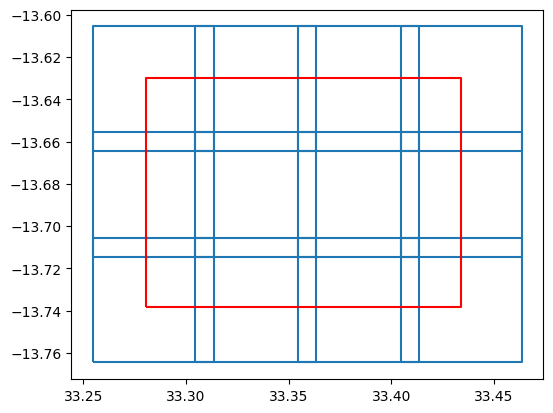

In [ ]:
# plot the aoi and tiles that were intersected
fig, ax = plt.subplots()
tiles_aoi.boundary.plot(ax=ax)
aoi.boundary.plot(ax=ax, color="red")
None

## Get the NICFI grid catalog for the tiles

### Query the catalog

We first create a function for defining the correct dates of imagery, which vary in terms of their length of monthly coverage. The date period has to be exact when querying the API to get the images back from Planet. Then use this to Find the Planet basemap quads that intersect the selected tiles.

In [ ]:
def year_date(year, month):
    if (year < "2021") & (month < "06"):
        date = str(int(year)-1) + "-12_" + year + "-05"
    elif (year < "2020") & (month == "12"):
        date = year + "-12_" + str(int(year)+1) + "-05"
    elif (year == "2020") & (month == "12"):
        date = year + '-' + month
    elif (year < "2020") & ((month >= "06") & (month < "12")):
        date = year + "-06_" + year + "-11"
    elif (year == "2020") & ((month >= "06") & (month < "09")):
        date = year + "-06_" + year + "-08"
    else:
        date = year + '-' + month
    return(date)

Run the query, which will give you a list of GeoDataFrames containing the quad tile name, date, download URL, as well as the tile ID of the tiling grid we use here.

But first specify the year and month(s) of interest. In this example, we are using June, 2021.

In [ ]:
date = year_date("2021", "06")

Then fetch the intersecting basemap quad grid.

In [ ]:
pdl = planet_downloader.PlanetDownloader()
quads_gdf, quads_url = pdl.get_basemap_grid(
    PLANET_API_KEY, API_URL, dates=[date],
    bbox=tiles_aoi.dissolve().iloc[0]["geometry"].bounds
)

None does not exist. Creating the catalog...


In [ ]:
quads_gdf.head()

,tile,date,geometry,file
0,1213-945,2021-06,"POLYGON ((33.39844 -13.75272, 33.39844 -13.581...",planet_medres_normalized_analytic_2021-06_mosa...
1,1214-945,2021-06,"POLYGON ((33.57422 -13.75272, 33.57422 -13.581...",planet_medres_normalized_analytic_2021-06_mosa...
2,1213-944,2021-06,"POLYGON ((33.39844 -13.92340, 33.39844 -13.752...",planet_medres_normalized_analytic_2021-06_mosa...
3,1214-944,2021-06,"POLYGON ((33.57422 -13.92340, 33.57422 -13.752...",planet_medres_normalized_analytic_2021-06_mosa...


After iterating through the tile grid and querying the catalog, combine the results into a single GeoDataFrame, which you can save to a geojson, which lists the tiles you need to cover each grid.  

In [ ]:
tiles_quads = tiles_aoi.sjoin(quads_gdf.rename(columns={"tile": "quad"}))\
    .drop(columns="index_right")\
    .iloc[:,[0,4,5,6,3]]

In [ ]:
tiles_quads.to_file(
    Path(proj_path) / "tiles_quads.geojson", driver="GeoJSON"
)

### Download and retile multiple quads

For the case when one of our tiles overlaps The code below shows how to find which tiles overlap the largest number of different Planet quads.

In [ ]:
# set up tile and temporary directory
if not os.path.isdir(tile_dir):
    os.makedirs(tile_dir)
if not os.path.isdir(quad_dir):
    os.makedirs(quad_dir)
if not os.path.isdir(temp_dir):
    os.makedirs(temp_dir)

List of all the tiles in the tiles_quads to be downloaded

In [ ]:
tids = list(tiles_quads.tile.unique())
tids

['899677',
 '899678',
 '899679',
 '899697',
 '899698',
 '899699',
 '899717',
 '899718',
 '899719',
 '899680',
 '899700',
 '899720']

### Download the list of tiles

In [ ]:
# Getting started
download_url = f"{quads_url}/<id>/full?api_key={PLANET_API_KEY}"

tids = list(tiles_quads.tile.unique())
for tid in tids:
    print(f"Processing {tid}")

    # quad to download and tile boundary
    tiles_quads_ss = tiles_quads[tiles_quads.tile==tid]
    poly = tiles[tiles.tile==tid]

    # download each quad in a loop
    print(f".downloading {tiles_quads_ss.shape[0]} quads")
    filenames = []
    for i, row in tiles_quads_ss.iterrows():
        print(i)
        link = get_quad_download_url(download_url, row['quad'])
        filename = f"{quad_dir}/{row['file']}.tif"
        filenames.append(filename)
        download_tiles_helper(link, filename)

    # reproject/retile
    print(f"./retiling")
    transform = dst_transform(poly)
    dst_img = f"{tile_dir}/tile{tid}_{row['date']}" +\
            f"_buf{int((dst_width-2000)/2)}.tif"
    dst_cog = re.sub('.tif', '_cog.tif', dst_img)

    # run retiler
    if not os.path.isfile(dst_img) or not os.path.isfile(dst_cog):
        reproject_retile_image(
            filenames, transform, dst_width, dst_height, nbands, dst_crs,
            dst_img, temp_dir, dst_dtype = np.int16, inmemory = False,
            cleanup=True
        )

    # COGify
    print(f".COG-ifying")
    if not os.path.isfile(dst_cog):

        # create COG from tile
        cmd = ['rio', 'cogeo', 'create', '-b', '1,2,3,4', dst_img, dst_cog]
        p = run(cmd, capture_output=True)
        msg = p.stderr.decode().split('\n')
        # print(f'...{msg[-2]}')

        cmd = ['rio', 'cogeo', 'validate', dst_cog]
        p = run(cmd, capture_output = True)
        msg = p.stdout.decode().split('\n')
        print(f'...{msg[0]}')

    # clean up
    print(f".tidying")
    if os.path.exists(dst_cog):
        if os.path.exists(dst_img):
            os.remove(dst_img)

Processing 899677
.downloading 1 quads
2191
Downloaded: /content/gdrive/MyDrive/Earth_Observations/Homework/Part2/quads/planet_medres_normalized_analytic_2021-06_mosaic_1213-945.tif
./retiling
..mosaicking 1 images
....creating temporary mosaick /content/gdrive/MyDrive/Earth_Observations/Homework/Part2/temp/0ky1qilg_mosaic.tif
..reprojecting, retiling tile899677_2021-06_buf179.tif
....removing temporary mosaick /content/gdrive/MyDrive/Earth_Observations/Homework/Part2/tiles/tile899677_2021-06_buf179.tif
Retiling and reprojecting of /content/gdrive/MyDrive/Earth_Observations/Homework/Part2/tiles/tile899677_2021-06_buf179.tif complete!
.COG-ifying
.../content/gdrive/MyDrive/Earth_Observations/Homework/Part2/tiles/tile899677_2021-06_buf179_cog.tif is a valid cloud optimized GeoTIFF
.tidying
Processing 899678
.downloading 1 quads
2192
File already exists: /content/gdrive/MyDrive/Earth_Observations/Homework/Part2/quads/planet_medres_normalized_analytic_2021-06_mosaic_1213-945.tif
./retiling

## Randomly select a retiled and plot against the tile quad

In [ ]:
# cog_tiles that will be randomly sampled
cog_tiles = [f"{tile_dir}/{tile}" for tile in os.listdir(tile_dir)
             if ".xml" not in tile]
cog_tiles

['/content/gdrive/MyDrive/Earth_Observations/Homework/Part2/tiles/tile913750_2021-06_buf179_cog.tif',
 '/content/gdrive/MyDrive/Earth_Observations/Homework/Part2/tiles/tile913751_2021-06_buf179_cog.tif',
 '/content/gdrive/MyDrive/Earth_Observations/Homework/Part2/tiles/tile913770_2021-06_buf179_cog.tif',
 '/content/gdrive/MyDrive/Earth_Observations/Homework/Part2/tiles/tile913771_2021-06_buf179_cog.tif',
 '/content/gdrive/MyDrive/Earth_Observations/Homework/Part2/tiles/tile913790_2021-06_buf179_cog.tif',
 '/content/gdrive/MyDrive/Earth_Observations/Homework/Part2/tiles/tile913791_2021-06_buf179_cog.tif',
 '/content/gdrive/MyDrive/Earth_Observations/Homework/Part2/tiles/tile913752_2021-06_buf179_cog.tif',
 '/content/gdrive/MyDrive/Earth_Observations/Homework/Part2/tiles/tile913753_2021-06_buf179_cog.tif',
 '/content/gdrive/MyDrive/Earth_Observations/Homework/Part2/tiles/tile913772_2021-06_buf179_cog.tif',
 '/content/gdrive/MyDrive/Earth_Observations/Homework/Part2/tiles/tile913773_2021-

In [ ]:
import random

# randomly select a tile
rand_tile = random.choice(cog_tiles)
with rasterio.open(rand_tile) as src:
    img = src.read()

# ploting the sample retiled tile against the tiles_quad
m = leafmap.Map()
m.add_basemap()
m.add_basemap("SATELLITE")
m.add_raster(rand_tile, bands=[3,2,1], layer_name="Retiled Planet no stretch")
m.add_gdf(tiles_quads, zoom_to_layer=True, layer_name="Tile")
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## Create STAC CATALOG

Import rasterio and pystac for STAC Catalog

In [ ]:
import rasterio as rio
from rasterio.features import bounds
from rasterio.plot import show, reshape_as_raster, reshape_as_image # will be used the bonus section
from pyproj import Transformer
from rasterio.transform import Affine

import pystac
import json
from datetime import datetime, timezone
from shapely.geometry import Polygon, mapping

create the catalog

In [ ]:
catalog = pystac.Catalog(
    id='Malawi_Tiles_catalog',
    description='This is a catalog of retiled tiles for Malawi'
)

boundingbox of the random sampled retiled tile

In [ ]:
def get_bbox_and_footprint(image):
    with rio.open(image) as r:
        bounds = r.bounds
        bbox = [bounds.left, bounds.bottom, bounds.right, bounds.top]
        footprint = Polygon([
            [bounds.left, bounds.bottom],
            [bounds.left, bounds.top],
            [bounds.right, bounds.top],
            [bounds.right, bounds.bottom]
        ])

        return (bbox, mapping(footprint))

# Run the function and print out the results
bbox, footprint = get_bbox_and_footprint(rand_tile)
print("bbox: ", bbox, "\n")
print("footprint: ", footprint)

bbox:  [35.054525, -14.964475, 35.113475, -14.905525] 

footprint:  {'type': 'Polygon', 'coordinates': (((35.054525, -14.964475), (35.054525, -14.905525), (35.113475, -14.905525), (35.113475, -14.964475), (35.054525, -14.964475)),)}


use the datetime of one of the tiles

In [ ]:
date = "2021-06-15:12:00:00"
from datetime import datetime, timezone
datetime = datetime.strptime(date, "%Y-%m-%d:%H:%M:%S").replace(tzinfo=timezone.utc)
datetime

datetime.datetime(2021, 6, 15, 12, 0, tzinfo=datetime.timezone.utc)

## convert the cog_tiles to data frame

In [ ]:
tiles = pd.DataFrame({"date": datetime, "tile": cog_tiles})


# Add each cog tile to the collection

In [ ]:
for i, row in tiles.iterrows():

    # Get bbox/footprint
    bbox, footprint = get_bbox_and_footprint(row["tile"])
      # create an item
    tile_id = "Planet_" + re.sub(".tif", "", os.path.basename(row["tile"]))
    #print(f"Processing {file_id}")

    item = pystac.Item(
        id=os.path.basename(tile_id),
        geometry=footprint,
        bbox=bbox,
        datetime=row["date"],
        properties={}
    )
    catalog.add_item(item)

    # Add Asset and all its information to Item
    item.add_asset(
        key='image',
        asset=pystac.Asset(
            href=row["tile"],
            media_type=pystac.MediaType.GEOTIFF
        )
    )

    catalog.normalize_hrefs(os.path.join(os.path.dirname(row["tile"]), "Tiles_Stac"))

# save the catalog
catalog.save(catalog_type=pystac.CatalogType.ABSOLUTE_PUBLISHED)



 ## get the properties of the tile stac

In [ ]:
items = list(catalog.get_all_items())
print(f"Number of items: {len(items)}")

for item in items:
    print(item)
    for asset_key in item.assets:
        asset = item.assets[asset_key]
        # print('{}: {} ({})'.format(asset_key, asset.href, asset.media_type))
        print(f"..{asset.href}")

    print(f'..{item.properties["datetime"]}')

Number of items: 27
<Item id=Planet_tile913750_2021-06_buf179_cog>
../content/gdrive/MyDrive/Earth_Observations/Homework/Part2/tiles/tile913750_2021-06_buf179_cog.tif
..2021-06-15T12:00:00Z
<Item id=Planet_tile913751_2021-06_buf179_cog>
../content/gdrive/MyDrive/Earth_Observations/Homework/Part2/tiles/tile913751_2021-06_buf179_cog.tif
..2021-06-15T12:00:00Z
<Item id=Planet_tile913770_2021-06_buf179_cog>
../content/gdrive/MyDrive/Earth_Observations/Homework/Part2/tiles/tile913770_2021-06_buf179_cog.tif
..2021-06-15T12:00:00Z
<Item id=Planet_tile913771_2021-06_buf179_cog>
../content/gdrive/MyDrive/Earth_Observations/Homework/Part2/tiles/tile913771_2021-06_buf179_cog.tif
..2021-06-15T12:00:00Z
<Item id=Planet_tile913790_2021-06_buf179_cog>
../content/gdrive/MyDrive/Earth_Observations/Homework/Part2/tiles/tile913790_2021-06_buf179_cog.tif
..2021-06-15T12:00:00Z
<Item id=Planet_tile913791_2021-06_buf179_cog>
../content/gdrive/MyDrive/Earth_Observations/Homework/Part2/tiles/tile913791_2021-0